# Introduction

How much does what is included in the annotation set matter?

In [1]:
import seaborn
import scipy
import anndata
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot, cm
import sys
import pysam
from collections import Counter
from IPython import display

import upsetplot

In [2]:
pandas.options.display.max_rows = 300

In [3]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/lung/ENCSR966DDY_16f_nuc'

In [4]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [5]:
v29_genome_dir = Path("~/proj/genome/").expanduser()
v29_store = pandas.HDFStore(v29_genome_dir / "GRCh38-V29-male" / "GRCh38-V29-male.h5")
v29_gtf = v29_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v29_store.close()

v29_gene_base_to_id = {}
v29_gene_id_to_name = {}
v29_gene_id_to_type = {}
for i, row in v29_gtf.iterrows():
    v29_gene_base_to_id[row.gene_id.split('.')[0]] = row.gene_id
    v29_gene_id_to_name[row.gene_id] = row.gene_name
    v29_gene_id_to_type[row.gene_id] = row.gene_type

def calculate_v29_gene_base(gene_id):
    gene_base = gene_id.split('.')[0]
    if gene_id.endswith("_PAR_Y"):
        gene_base += "_PAR_Y"
    return gene_base
v29_gtf['gene_base'] = v29_gtf['gene_id'].apply(calculate_v29_gene_base)

In [6]:
v32m_genome_dir = Path("~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/").expanduser()
v32m_store = pandas.HDFStore(v32m_genome_dir / "GRCh38-arc2.0-2.7.8a" / "GRCh38-arc2.0-2.7.8a.h5")
v32m_gtf = v32m_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v32m_store.close()

v32m_gtf.columns = ['gene_base', 'gene_name', 'gene_type']
v32m_gtf['gene_id'] = v32m_gtf['gene_base'].apply(lambda x: v29_gene_base_to_id.get(x, x))

v32m_gene_id_to_name = {}
v32m_gene_id_to_type = {}
for i, row in v32m_gtf.iterrows():
    v32m_gene_id_to_name[row.gene_id] = row.gene_name
    v32m_gene_id_to_type[row.gene_id] = row.gene_type

In [7]:
def scanpy_load_solo278a_mtx(analysis_dir, quantification="Gene", mode="filtered", multiread="Unique"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "GeneFull_Ex50pAS", "SJ"]
    MULTIREAD_MATRIX = {
    "Unique": "matrix.mtx",
    "Rescue": "UniqueAndMult-Rescue.mtx",
    "EM": "UniqueAndMult-EM.mtx",
    }
    assert multiread in MULTIREAD_MATRIX

    analysis_dir = Path(analysis_dir)
    
    solo_dir = analysis_dir / "Solo.out" / quantification 
    solo = scanpy.read_mtx(solo_dir / "raw" / MULTIREAD_MATRIX[multiread]).T
    solo_vars = pandas.read_csv(
        solo_dir / "raw" / "features.tsv", header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "raw" / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]
    
    if mode == "filtered":
        solo_obs = pandas.read_csv(
            solo_dir / mode / "barcodes.tsv", header=None, sep="\t"
        ).values.T[0]
        solo = solo[solo_obs,:]
        

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



# Load Datasets

In [8]:
algorithm_roots = {
    'tenx solo uniq': (Path("tenxsolo_multi_dev_EoI_2.7.9a_2021-09-10"), "GeneFull_Ex50pAS", "filtered", "Unique"),
    'encode full solo uniq': (Path("fullsolo_multi_dev_EoI_2.7.9a_2021-09-10"), "GeneFull_Ex50pAS", "filtered", "Unique"),
}

In [9]:
algorithm_filtered = {}
for algorithm in algorithm_roots:
    root, quantification, filtering, multiread = algorithm_roots[algorithm]
    print("loading {}".format(algorithm))
    algorithm_filtered[algorithm] = scanpy_load_solo278a_mtx(root, quantification, filtering, multiread)
    print(algorithm, algorithm_filtered[algorithm].shape, algorithm_filtered[algorithm].X.sum())

loading tenx solo uniq


Trying to set attribute `.obs` of view, copying.


tenx solo uniq (8531, 36601) 38550680.0
loading encode full solo uniq


Trying to set attribute `.obs` of view, copying.


encode full solo uniq (8435, 59526) 37205424.0


# Add (faked) version to 10x annotation

The 10x provided annotation GTF file, based on GENCODE V32, has the gene version number removed, to make later comparisons easier I added the gene version number from my V29 GTF on to the V32 gene base ids.

(Gene base = ENSG00000243485)

(Gene id with version = ENSG00000243485.5)

In [10]:
for algorithm in algorithm_filtered:
    if algorithm.startswith("tenx"):
        algorithm_filtered[algorithm].var_names = v32m_gtf.set_index('gene_base').reindex(algorithm_filtered[algorithm].var_names.to_list())['gene_id']

# Remove version from ENCODE annotations

In [11]:
#algorithm_filtered['encode minimal solo uniq'].var_names

In [12]:
#for algorithm in algorithm_filtered:
#    if algorithm != 'tenx solo uniq':
#        algorithm_filtered[algorithm].var_names = [x.split('.')[0] for x in algorithm_filtered[algorithm].var_names]


In [13]:
#algorithm_filtered['encode minimal solo uniq'].var_names

# Cell barcodes in common

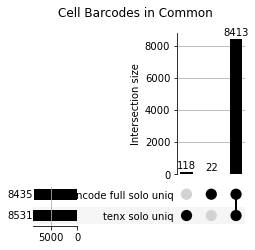

In [14]:
algorithm_cell_barcodes = {}
for algorithm in algorithm_filtered:
    algorithm_cell_barcodes[algorithm] = algorithm_filtered[algorithm].obs_names

common_cell_barcode_set = upsetplot.from_contents(algorithm_cell_barcodes)
f = pyplot.figure()
f.suptitle("Cell Barcodes in Common")
_ = upsetplot.plot(common_cell_barcode_set, fig=f, show_counts=True)


In [15]:
common_cell_barcode_set = None
for algorithm in algorithm_filtered:
    if common_cell_barcode_set is None:
        common_cell_barcode_set = set(algorithm_filtered[algorithm].obs_names)
    else:
        common_cell_barcode_set = common_cell_barcode_set.intersection(algorithm_filtered[algorithm].obs_names)

print('common_cell_barcode_set', len(common_cell_barcode_set))
common_cell_barcodes = [x for x in algorithm_filtered['encode full solo uniq'].obs_names if x in common_cell_barcode_set]
print('common_cell_barcodes', len(common_cell_barcodes))


common_cell_barcode_set 8413
common_cell_barcodes 8413


# Gene IDs in common

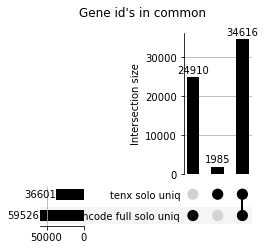

In [16]:
algorithm_gene_base_ids = {}
for algorithm in algorithm_filtered:
    algorithm_gene_base_ids[algorithm] = set(algorithm_filtered[algorithm].var_names)

common_gene_base_contents = upsetplot.from_contents(algorithm_gene_base_ids)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
f = pyplot.figure()
f.suptitle("Gene id's in common")
_ = upsetplot.plot(common_gene_base_contents, fig=f, show_counts=True)

In [17]:
common_gene_id_set = None
for algorithm in algorithm_filtered:
    #if algorithm == 'tenx solo uniq':
    #    continue
    if common_gene_id_set is None:
        common_gene_id_set = set(algorithm_filtered[algorithm].var_names)
    else:
        common_gene_id_set = common_gene_id_set.intersection(algorithm_filtered[algorithm].var_names)

print("common_gene_id_set", len(common_gene_id_set), len(set(common_gene_id_set)))
common_gene_ids = [x for x in algorithm_filtered['encode full solo uniq'].var_names if x in common_gene_id_set]
print("common_gene_ids", len(common_gene_ids), len(set(common_gene_ids)))

common_gene_id_set 34616 34616
common_gene_ids 34616 34616


In [18]:
#tenx_gene_base = set(algorithm_filtered['tenx solo uniq'].var_names)
#v29_common_gene_base = [x.split('.')[0] for x in algorithm_filtered['encode full solo uniq'].var_names if x.split('.')[0] in tenx_gene_base and x in common_gene_ids]
#v29_common_gene_ids = [x for x in algorithm_filtered['encode full solo uniq'].var_names if x.split('.')[0] in tenx_gene_base and x in common_gene_ids]
#print(len(v29_common_gene_base), v29_common_gene_base[:5])

In [19]:
algorithm_common = {}
for algorithm in algorithm_filtered:
    algorithm_common[algorithm] = algorithm_filtered[algorithm][common_cell_barcodes, common_gene_ids]
    print(algorithm, algorithm_common[algorithm].shape, algorithm_common[algorithm].X.sum())

tenx solo uniq (8413, 34616) 38374440.0
encode full solo uniq (8413, 34616) 36607790.0


# Compute correlations of cells in common between all methods

In [20]:
def compute_spearman_anndata(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    if isinstance(left, anndata._core.anndata.AnnData):
        left = left.to_df().T
    if isinstance(right, anndata._core.anndata.AnnData):
        right = right.to_df().T

    #print(left.shape[0])
    #print(left[0].shape)
    #print(right[0].shape)
    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors


def compute_correlations(table):
    programs = list(table.keys())
    correlations = {}
    dense = {}
    for name_x in programs:
        dense[name_x] = table[name_x].to_df().T

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            print("Processing {} {}".format(name_x, name_y))
            cs_cors = compute_spearman_anndata(dense[name_x], dense[name_y])
            correlations.setdefault(name_x, {})[name_y] = cs_cors
    return correlations

algorithm_correlations = compute_correlations(algorithm_common)

Processing tenx solo uniq tenx solo uniq
Processing tenx solo uniq encode full solo uniq
Processing encode full solo uniq encode full solo uniq


In [21]:
def plot_cell_correlation_histogram(table, title=None, bins=50, programs=None):
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)
    if title is not None:
        f.suptitle(title.format(metric=metric))

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            spearman = numpy.array(table[name_x][name_y])
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCount {count}', xy=(0.1, 0.6), xycoords='axes fraction')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    #f.tight_layout()
    

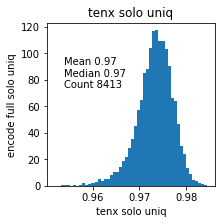

In [22]:
plot_cell_correlation_histogram(algorithm_correlations)

# Scatter plot of method genes in common over all cells

In [23]:
def plot_algorithm_sums(table, title=None, programs=None):
    if programs is None:
        programs = list(table.keys())
    scatter = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)    
    if title is not None:
        f.suptitle(title.format(metric=metric))

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            scatter.setdefault(name_x, {})[name_y] = ax.scatter(
                numpy.asarray(table[name_x].X.sum(axis=1).T)[0], 
                numpy.asarray(table[name_y].X.sum(axis=1).T)[0],
                s=0.5
            )
            ax.set_xscale('log')
            ax.set_yscale('log')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("per algorithm sum of genes over all cells")
    #f.tight_layout()
    

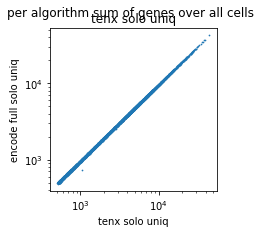

In [24]:
plot_algorithm_sums(algorithm_common)

# Scatter plots of gene expression for worst, median, and best correlated cells

In [25]:
algorithm_dense = {}
for algorithm in algorithm_common:
    algorithm_dense[algorithm] = algorithm_common[algorithm].to_df().T


In [26]:
def sc_scatter(table, correlations, name_x, name_y, cell_id, ax=None):
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in table[name_x].index]

    ax.plot([-5,10], [-5,10], c=set1[2])
    ax.scatter(numpy.log2(table[name_x][cell_id]+0.01), numpy.log2(table[name_y][cell_id]+0.01), color=colors, s=2)
    spearman = correlations[name_x][name_y][cell_id]
    expressed_in_x = table[name_x][cell_id] > 0
    expressed_in_y = table[name_y][cell_id] > 0
    count = table[name_x][expressed_in_x & expressed_in_y].shape[0]
    ax.set_title(f'id {cell_id}\nSpearman {spearman:0.4}\nCount: {count}')
    ax.set_xlabel(name_x)
    ax.set_ylabel(name_y)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)

def show_scatter_extremes(dense_mat, correlations, name_x, name_y):
    scores = correlations[name_x][name_y]
    best_cell = scores.idxmax()
    worst_cell = scores.idxmin()
    # find smallest absolute difference from median and use that as median cell
    median = numpy.abs(scores - scores.median())
    median_cell = median.idxmin()
    
    f = pyplot.figure(figsize=(12,4))
    #f.suptitle(f'{metric} worst, median and best cells')
    axes = f.subplots(1,3, sharex=True, sharey=True)
    sc_scatter(dense_mat, correlations, name_x, name_y, worst_cell, ax=axes[0])
    sc_scatter(dense_mat, correlations, name_x, name_y, median_cell, ax=axes[1])
    sc_scatter(dense_mat, correlations, name_x, name_y, best_cell, ax=axes[2])
    return f

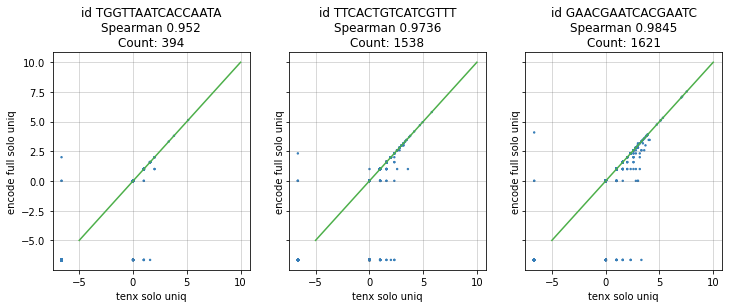

In [27]:
f = show_scatter_extremes(algorithm_dense, algorithm_correlations, 'tenx solo uniq', 'encode full solo uniq')

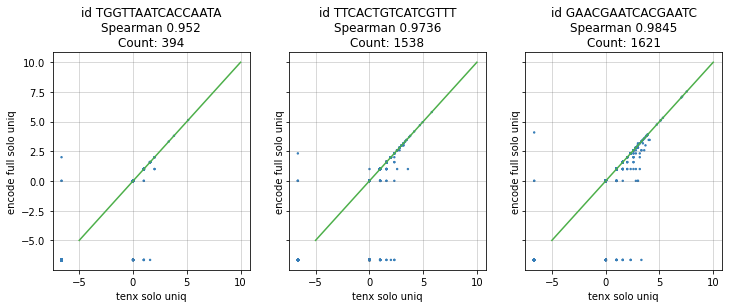

In [28]:
def plot_all_scatter_extremes(table, correlations):
    programs = list(table.keys())


    for name_x in programs:
        for name_y in programs[programs.index(name_x)+1:]:
            #print("Comparing {} {}".format(name_x, name_y))
            f = show_scatter_extremes(table, correlations, name_x, name_y)
            
            
plot_all_scatter_extremes(algorithm_dense, algorithm_correlations)

# Scatter plot of cells with the highest expression sum

In [29]:
def plot_algorithm_most_expressed(table, correlations, title=None, programs=None):
    if programs is None:
        programs = list(table.keys())
    scatter = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)
    if title is not None:
        f.suptitle(title.format(metric=metric))


    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            max_cell = algorithm_dense[name_x].sum(axis=0).idxmax()
            scatter.setdefault(name_x, {})[name_y] = sc_scatter(table, correlations, name_x, name_y, max_cell, ax=ax)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Compare algorithms with cell with highest expression sum")
    #f.tight_layout()
    

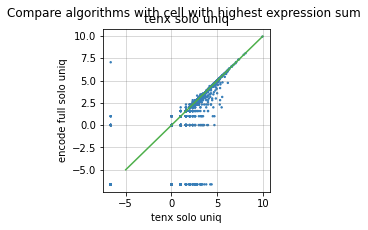

In [30]:
plot_algorithm_most_expressed(algorithm_dense, algorithm_correlations)

# Lets try the scanpy tutorial

tenx solo uniq first phase QC


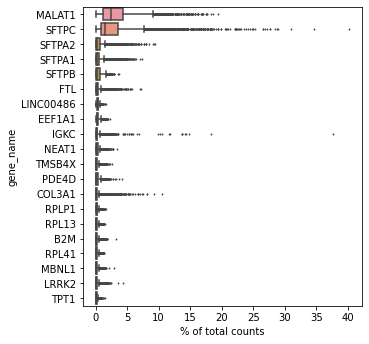

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

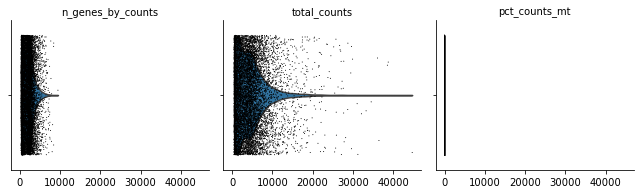

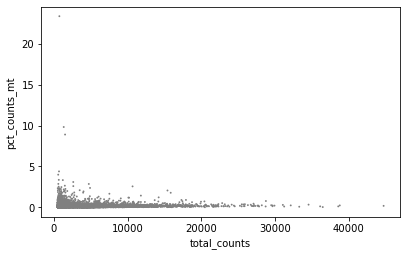

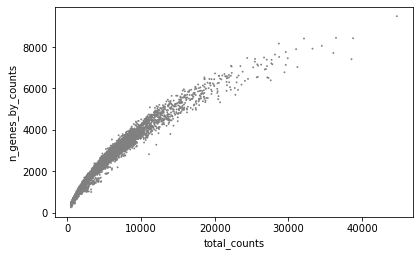

encode full solo uniq first phase QC


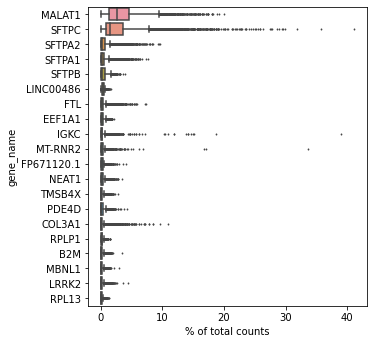

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

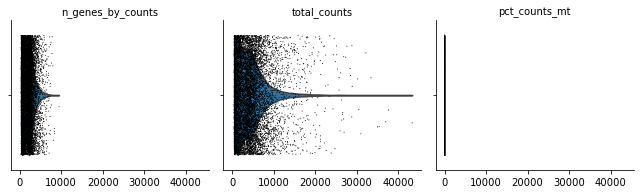

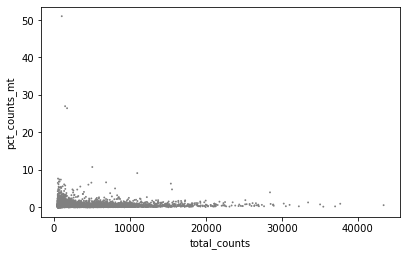

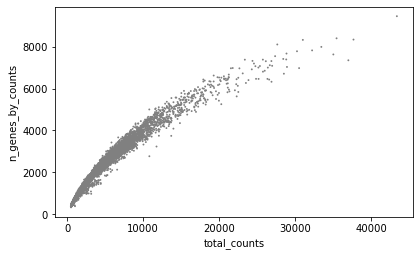

In [31]:
for algorithm in algorithm_filtered:
    print("{algorithm} first phase QC".format(algorithm=algorithm))    
    if algorithm.startswith("tenx"):
        algorithm_filtered[algorithm].var['gene_name'] = [v32m_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v32m_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
    else:
        algorithm_filtered[algorithm].var['gene_name'] = [v29_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v29_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        
    scanpy.pl.highest_expr_genes(algorithm_filtered[algorithm], n_top=20, gene_symbols='gene_name')
    scanpy.pp.filter_cells(algorithm_filtered[algorithm], min_genes=200)
    scanpy.pp.filter_genes(algorithm_filtered[algorithm], min_cells=3)
    algorithm_filtered[algorithm].var['mt'] = algorithm_filtered[algorithm].var['gene_name'].str.startswith("MT-")
    scanpy.pp.calculate_qc_metrics(algorithm_filtered[algorithm], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    scanpy.pl.violin(
        algorithm_filtered[algorithm],
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
        jitter=0.4, multi_panel=True)
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='pct_counts_mt')
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='n_genes_by_counts')        

tenx solo uniq clustering


/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


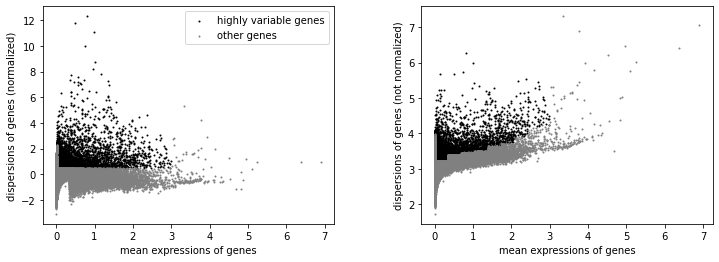

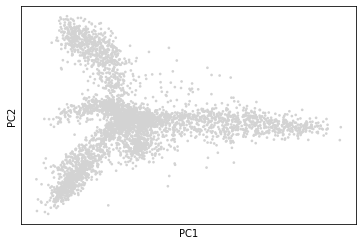

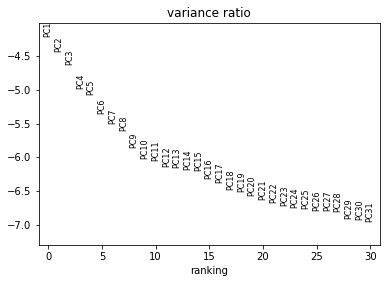

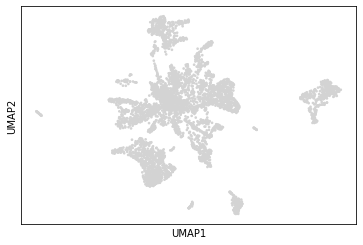

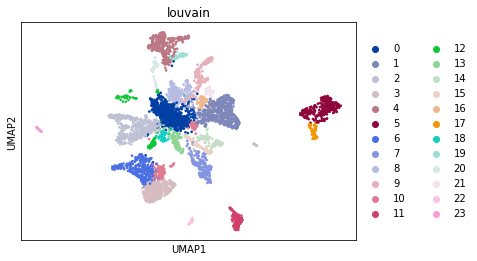

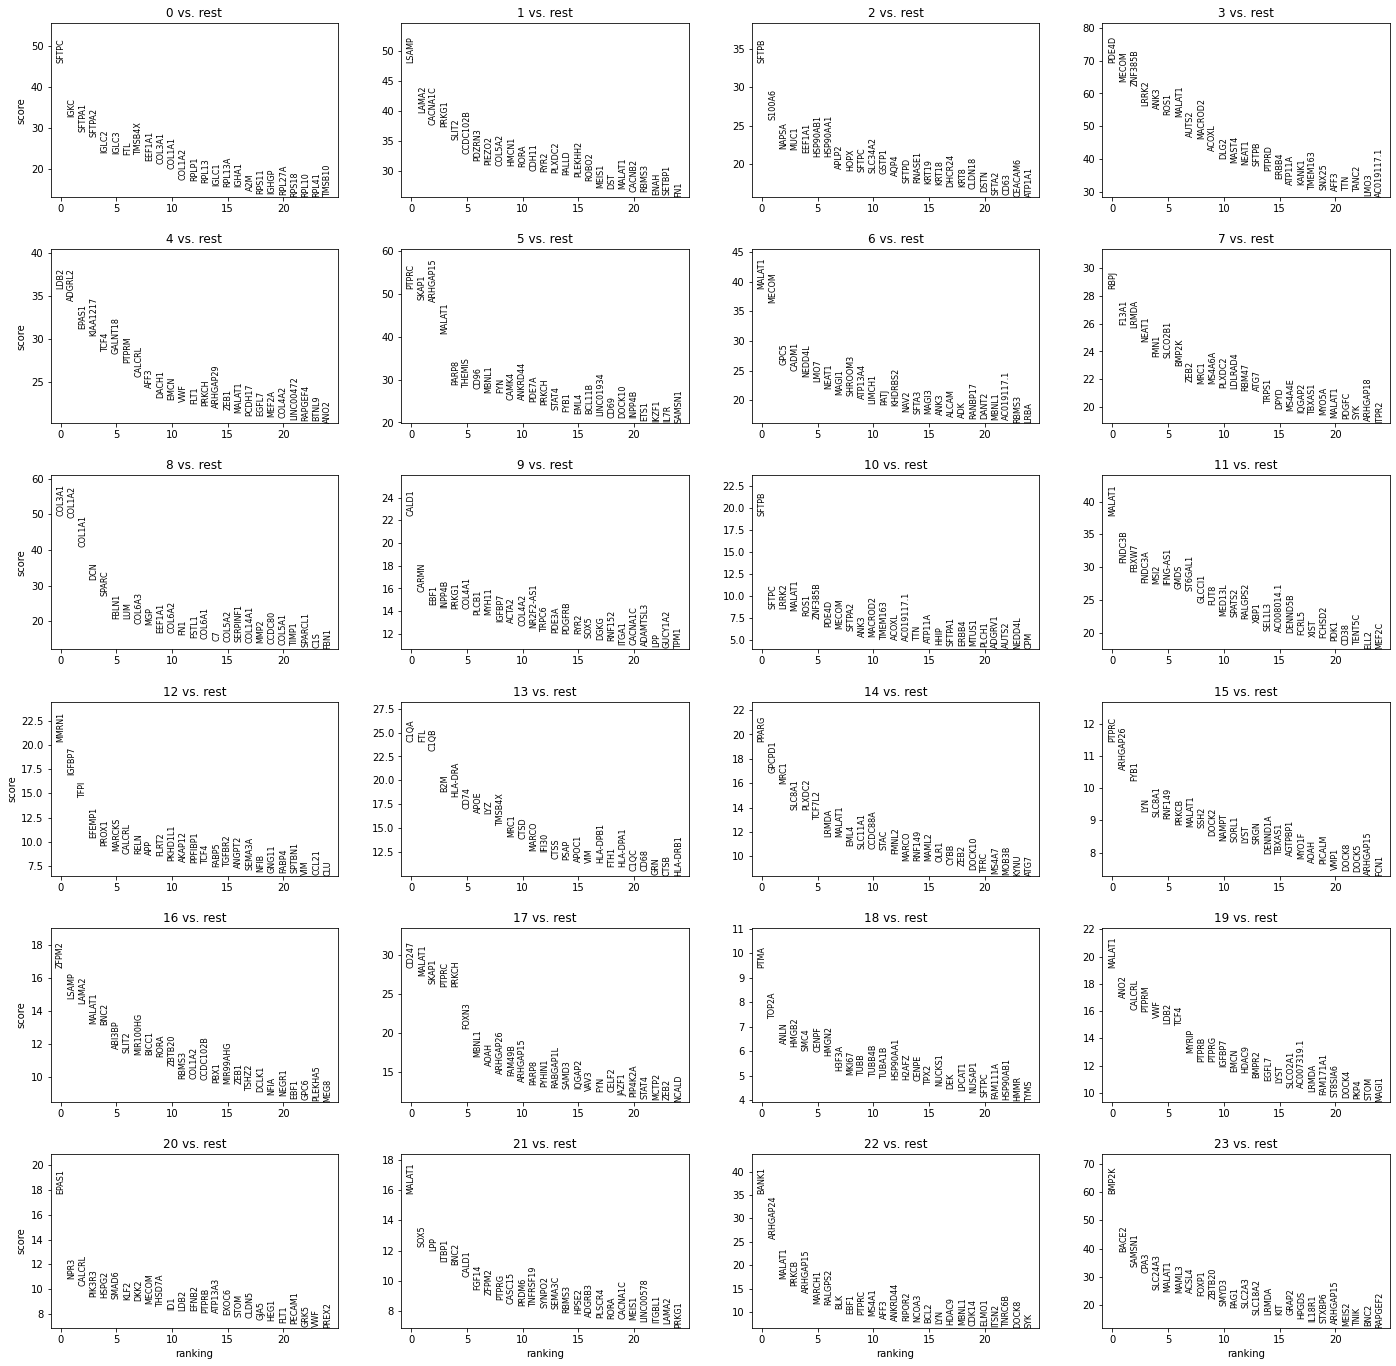

top gene names
        0        1       2        3         4         5       6      7  \
0   SFTPC    LSAMP   SFTPB    PDE4D      LDB2     PTPRC  MALAT1   RBPJ   
1    IGKC    LAMA2  S100A6    MECOM    ADGRL2     SKAP1   MECOM  F13A1   
2  SFTPA1  CACNA1C   NAPSA  ZNF385B     EPAS1  ARHGAP15    GPC5  LRMDA   
3  SFTPA2    PRKG1    MUC1    LRRK2  KIAA1217    MALAT1   CADM1  NEAT1   
4   IGLC2    SLIT2  EEF1A1     ANK3      TCF4     PARP8  NEDD4L   FMN1   

        8       9  ...      14        15      16      17     18      19  \
0  COL3A1   CALD1  ...   PPARG     PTPRC   ZFPM2   CD247   PTMA  MALAT1   
1  COL1A2   CARMN  ...  GPCPD1  ARHGAP26   LSAMP  MALAT1  TOP2A    ANO2   
2  COL1A1    EBF1  ...    MRC1      FYB1   LAMA2   SKAP1   ANLN  CALCRL   
3     DCN  INPP4B  ...  SLC8A1       LYN  MALAT1   PTPRC  HMGB2   PTPRM   
4   SPARC   PRKG1  ...  PLXDC2    SLC8A1    BNC2   PRKCH   SMC4     VWF   

       20      21        22       23  
0   EPAS1  MALAT1     BANK1    BMP2K  
1    NPR3  

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


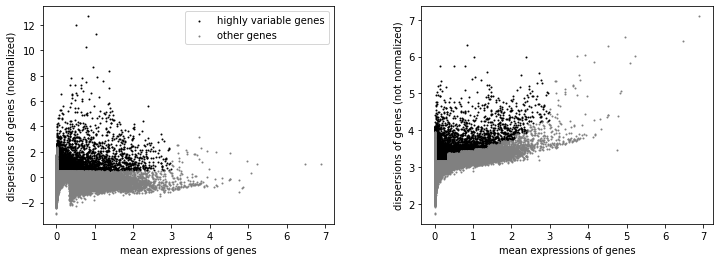

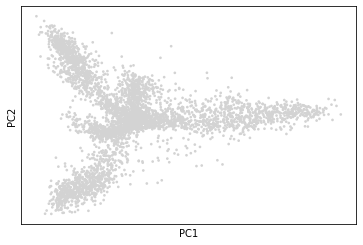

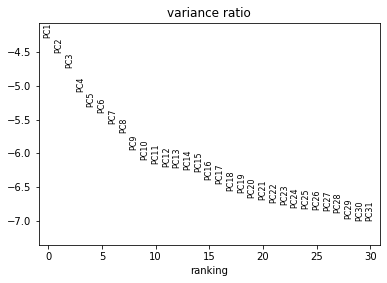

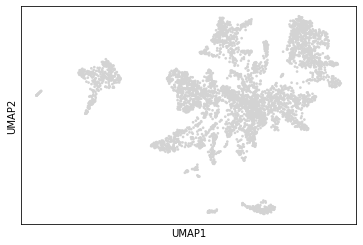

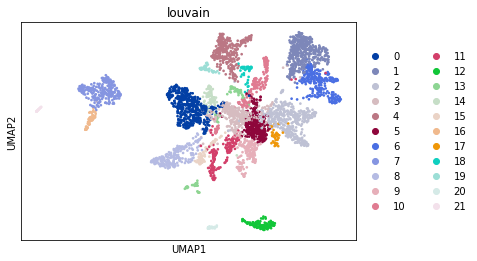

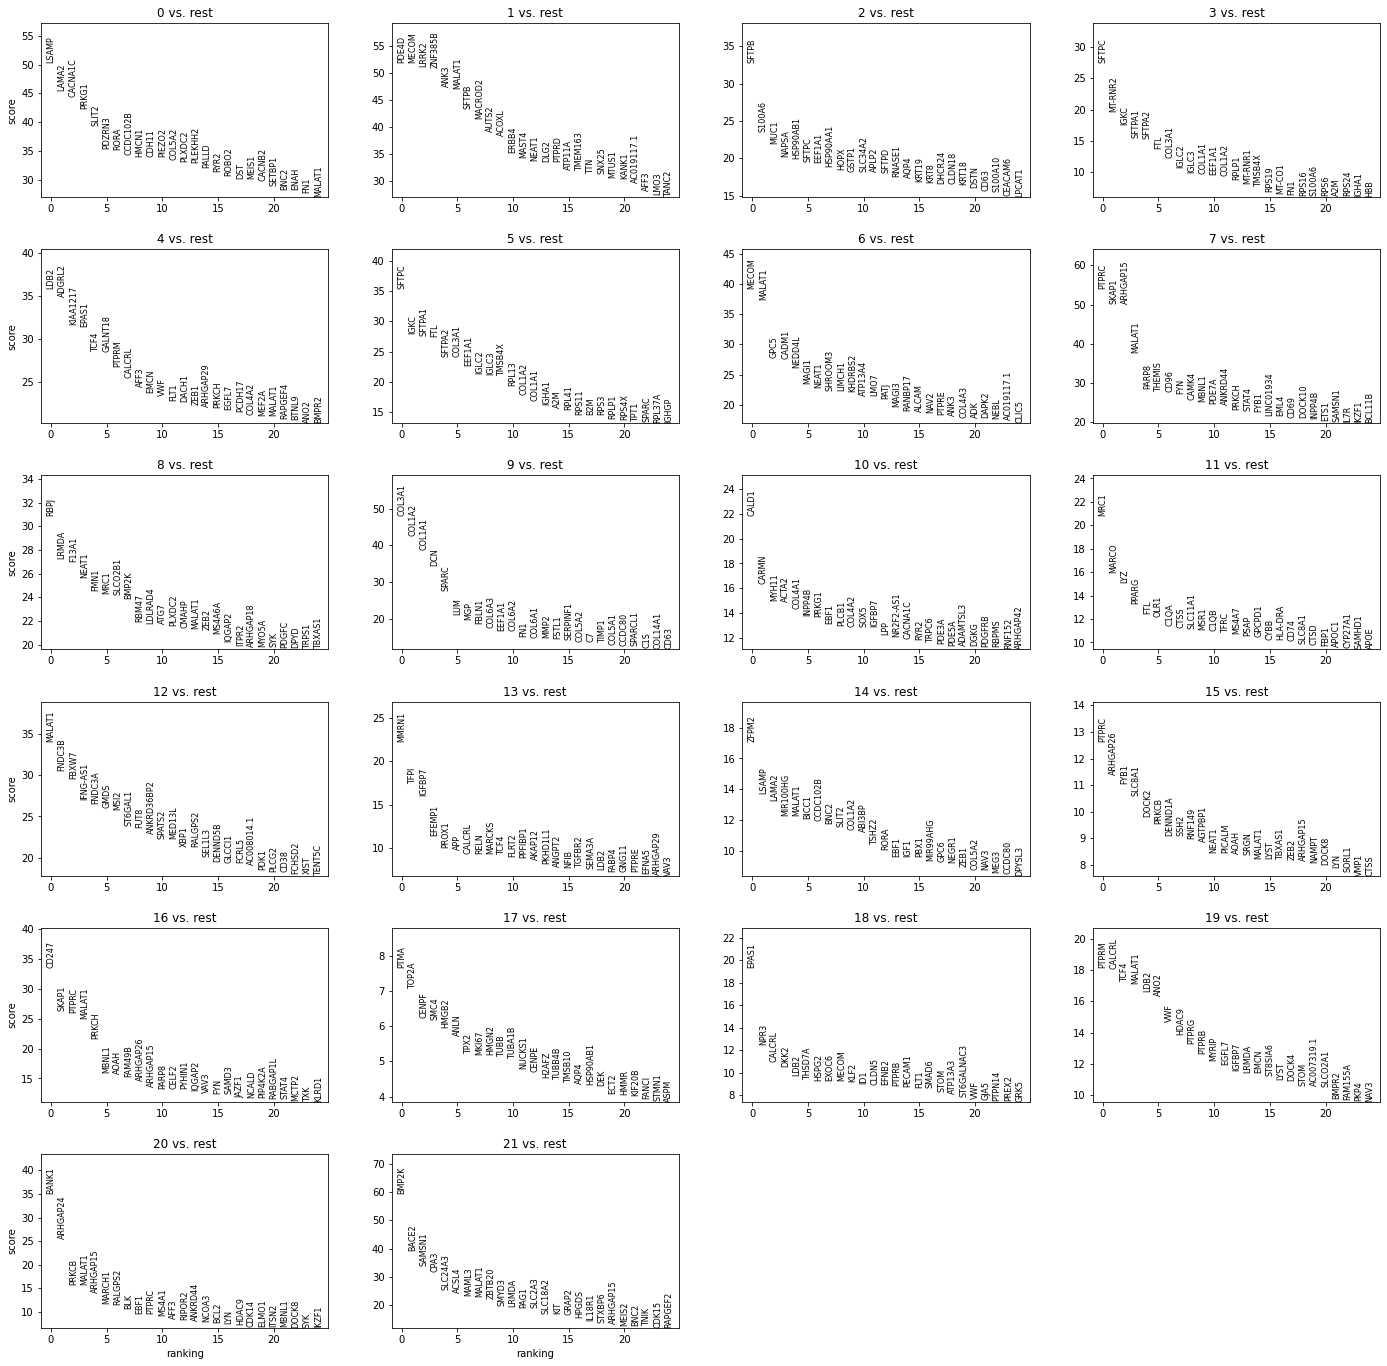

top gene names
         0        1         2        3         4       5       6         7  \
0    LSAMP    PDE4D     SFTPB    SFTPC      LDB2   SFTPC   MECOM     PTPRC   
1    LAMA2    MECOM    S100A6  MT-RNR2    ADGRL2    IGKC  MALAT1     SKAP1   
2  CACNA1C    LRRK2      MUC1     IGKC  KIAA1217  SFTPA1    GPC5  ARHGAP15   
3    PRKG1  ZNF385B     NAPSA   SFTPA1     EPAS1     FTL   CADM1    MALAT1   
4    SLIT2     ANK3  HSP90AB1   SFTPA2      TCF4  SFTPA2  NEDD4L     PARP8   

       8       9  ...        12      13        14        15      16     17  \
0   RBPJ  COL3A1  ...    MALAT1   MMRN1     ZFPM2     PTPRC   CD247   PTMA   
1  LRMDA  COL1A2  ...    FNDC3B    TFPI     LSAMP  ARHGAP26   SKAP1  TOP2A   
2  F13A1  COL1A1  ...     FBXW7  IGFBP7     LAMA2      FYB1   PTPRC  CENPF   
3  NEAT1     DCN  ...  IFNG-AS1  EFEMP1  MIR100HG    SLC8A1  MALAT1   SMC4   
4   FMN1   SPARC  ...    FNDC3A   PROX1    MALAT1     DOCK2   PRKCH  HMGB2   

       18      19        20       21  
0   EPAS

In [32]:
algorithm_scanpy_filtered = {}
algorithm_top_gene_ids = {}
algorithm_top_gene_names = {}
for algorithm in algorithm_filtered:
    #print(display.HTML('<h1>{algorithm} first phase QC</h1><a class="anchor-link" href="#{algorithm}-first-phase-QC">¶</a>'.format(algorithm=algorithm)))
    print("{algorithm} clustering".format(algorithm=algorithm))
    algorithm_scanpy_filtered[algorithm] = algorithm_filtered[algorithm][algorithm_filtered[algorithm].obs.n_genes_by_counts < 2000, :]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][algorithm_scanpy_filtered[algorithm].obs.pct_counts_mt < 2.5, :]
    
    scanpy.pp.normalize_total(algorithm_scanpy_filtered[algorithm], target_sum=30000)
    scanpy.pp.log1p(algorithm_scanpy_filtered[algorithm])
    scanpy.pp.highly_variable_genes(algorithm_scanpy_filtered[algorithm], min_mean=0.0125, max_mean=3, min_disp=0.5)
    scanpy.pl.highly_variable_genes(algorithm_scanpy_filtered[algorithm])
    algorithm_scanpy_filtered[algorithm].raw = algorithm_scanpy_filtered[algorithm]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][:, algorithm_scanpy_filtered[algorithm].var.highly_variable]
   
    scanpy.pp.regress_out( algorithm_scanpy_filtered[algorithm], ['total_counts', 'pct_counts_mt'])
    scanpy.pp.scale( algorithm_scanpy_filtered[algorithm], max_value=10)
    scanpy.tl.pca(algorithm_scanpy_filtered[algorithm], svd_solver='arpack')
    scanpy.pl.pca(algorithm_scanpy_filtered[algorithm])

    scanpy.pl.pca_variance_ratio(algorithm_scanpy_filtered[algorithm], log=True)
    
    scanpy.pp.neighbors(algorithm_scanpy_filtered[algorithm], n_neighbors=10, n_pcs=40)
    scanpy.tl.umap(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm])
    
    scanpy.tl.louvain(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm], color=['louvain'])
    
    scanpy.tl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], 'louvain', method='t-test')
    scanpy.pl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], n_genes=25, sharey=False, gene_symbols='gene_name')
    
    algorithm_top_gene_ids[algorithm] = pandas.DataFrame(algorithm_scanpy_filtered[algorithm].uns['rank_genes_groups']['names'])    
    if algorithm == "tenx solo uniq":
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v32m_gene_id_to_name.get(x, x))
    else:
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v29_gene_id_to_name.get(x, x))
    print('top gene names')
    print(algorithm_top_gene_names[algorithm].head(5))

# Cell barcodes left in common after scanpy filtering

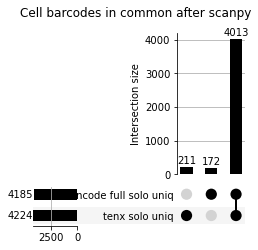

In [33]:
tutoral_barcode_set = upsetplot.from_contents({
    k: algorithm_scanpy_filtered[k].obs_names for k in algorithm_scanpy_filtered
})
f = pyplot.figure()
f.suptitle("Cell barcodes in common after scanpy")
_ = upsetplot.plot(tutoral_barcode_set, show_counts=True, fig=f)


# Gene IDs in common after scanpy filtering

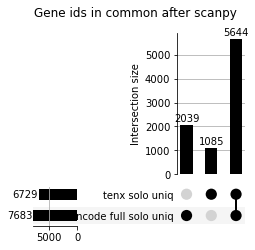

In [34]:
common_filtered_gene_base_contents = {}
for algorithm in algorithm_scanpy_filtered:
    #if algorithm == 'tenx solo uniq':
    #    common_filtered_gene_base_contents[algorithm] = {gene_id for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    #else:
    #common_filtered_gene_base_contents[algorithm] = {gene_id.split('.')[0] for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    common_filtered_gene_base_contents[algorithm] = set(algorithm_scanpy_filtered[algorithm].var_names)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
common_filtered_gene_base_set = upsetplot.from_contents(common_filtered_gene_base_contents)

f = pyplot.figure()
f.suptitle("Gene ids in common after scanpy")
_ = upsetplot.plot(common_filtered_gene_base_set, show_counts=True, fig=f)

In [35]:
common_filtered_gene_base_set

id
tenx solo uniq encode full solo uniq                    
True           True                   ENSG00000119574.12
               True                   ENSG00000176153.11
               True                    ENSG00000198468.7
               True                   ENSG00000164542.12
               True                   ENSG00000115896.15
...                                                  ...
False          True                    ENSG00000177369.8
               True                    ENSG00000284946.1
               True                    ENSG00000273344.1
               True                    ENSG00000181541.5
               True                    ENSG00000228142.2

[8768 rows x 1 columns]

In [36]:
#common_filtered_gene_base_set.loc[True, False, True]['id']

In [37]:
#v29_gtf.set_index('gene_id').reindex(common_filtered_gene_base_set.loc[True, False, True]['id'])

In [38]:
def build_confusion_matrix(left, right, N=20):
    confusion = {}
    for cluster in left:
        for gene in left[cluster].head(N):
            confusion.setdefault(gene, {})['left'] = int(cluster)

    for cluster in right:
        for gene in right[cluster].head(N):
            confusion.setdefault(gene, {})['right'] = int(cluster)

    last_left = int(left.columns[-1]) + 1
    last_right = int(right.columns[-1]) + 1

    confusion_matrix = numpy.zeros((last_left+1, last_right+1))

    for gene in confusion:
        x = confusion[gene].get('left', last_left)
        y = confusion[gene].get('right', last_right)
        confusion_matrix[x,y] += 1
    return confusion_matrix

# Confusion matrices between top N genes in each cluster

In [39]:
def plot_algorithm_confusion(table, programs=None, N=20):
    if programs is None:
        programs = list(table.keys())
    confusion = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            cm = build_confusion_matrix(table[name_x], table[name_y], N)
            seaborn.heatmap(cm, annot=False, ax=ax)
            
            if x == 0:
                ax.set_ylabel(name_y)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Gene name confusion matrix of top {} genes".format(N))
    #f.tight_layout()


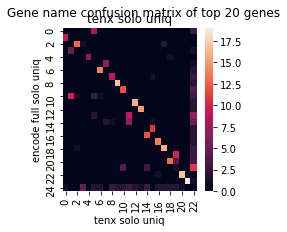

In [40]:
plot_algorithm_confusion(algorithm_top_gene_names, N=20)

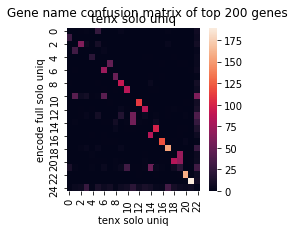

In [41]:
plot_algorithm_confusion(algorithm_top_gene_names, N=200)

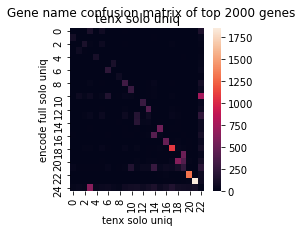

In [42]:
plot_algorithm_confusion(algorithm_top_gene_names, N=2000)

# Smoosh datasets

In [43]:
combined = anndata.concat(
    [algorithm_filtered[x] for x in algorithm_filtered],
    merge='same',
)
combined

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 16966 × 26184
    obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt'

In [44]:
combined.var['gene_name'] = [v29_gene_id_to_name.get(x, x) for x in combined.var_names]
combined.var['gene_type'] = [v29_gene_id_to_type.get(x, x) for x in combined.var_names]
combined

AnnData object with n_obs × n_vars = 16966 × 26184
    obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'gene_name', 'gene_type'

In [45]:
method = []
for algorithm in algorithm_filtered:
    method.extend([algorithm] * len(algorithm_filtered[algorithm].obs_names))
print(len(method), len(algorithm_filtered[algorithm].obs_names))
print(combined.shape)
combined.obs['method'] = method
combined

16966 8435
(16966, 26184)


AnnData object with n_obs × n_vars = 16966 × 26184
    obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'method'
    var: 'mt', 'gene_name', 'gene_type'

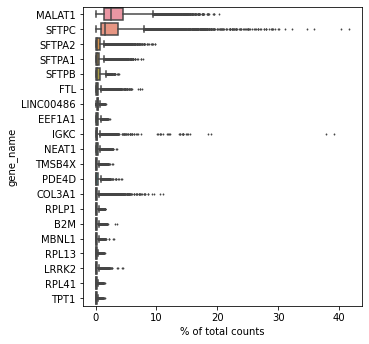

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'method' as categorical
... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))

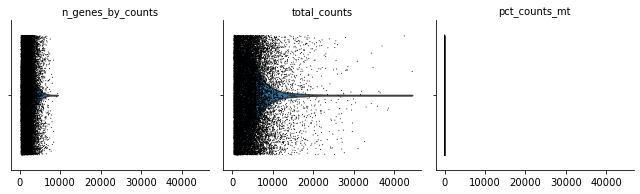

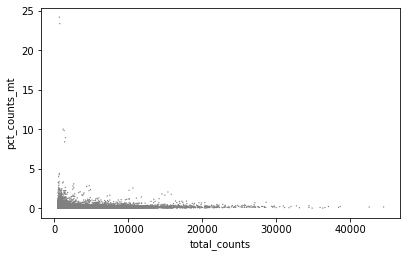

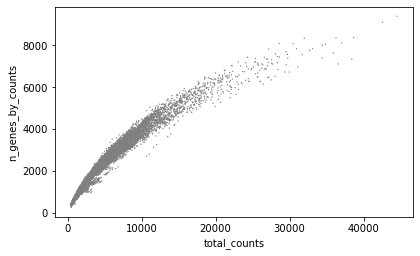

In [46]:
scanpy.pl.highest_expr_genes(combined, n_top=20, gene_symbols='gene_name')
scanpy.pp.filter_cells(combined, min_genes=200)
scanpy.pp.filter_genes(combined, min_cells=3)
algorithm_filtered[algorithm].var['mt'] = combined.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(combined, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
scanpy.pl.violin(
    combined,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True)
scanpy.pl.scatter(combined, x='total_counts', y='pct_counts_mt')
scanpy.pl.scatter(combined, x='total_counts', y='n_genes_by_counts')        

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


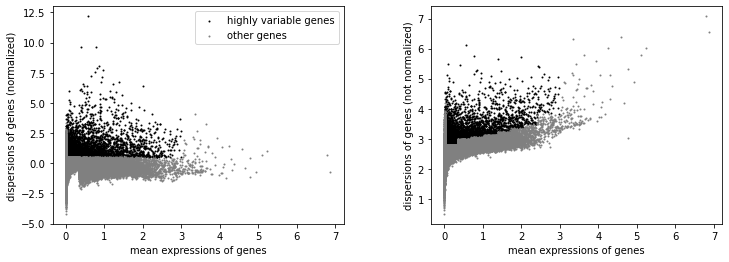

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


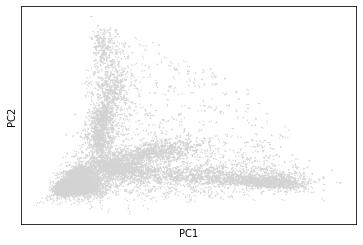

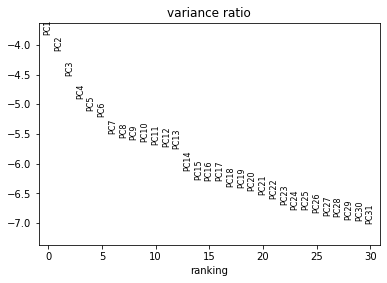

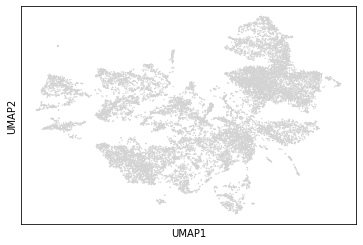

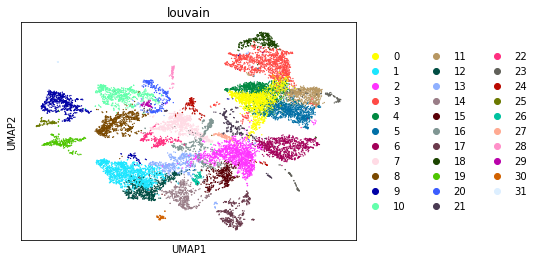

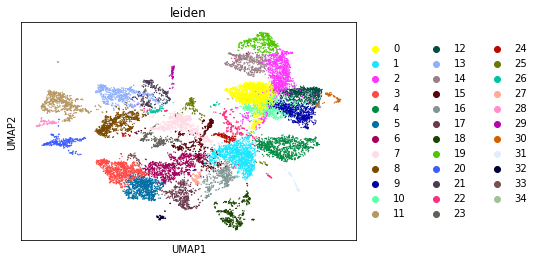

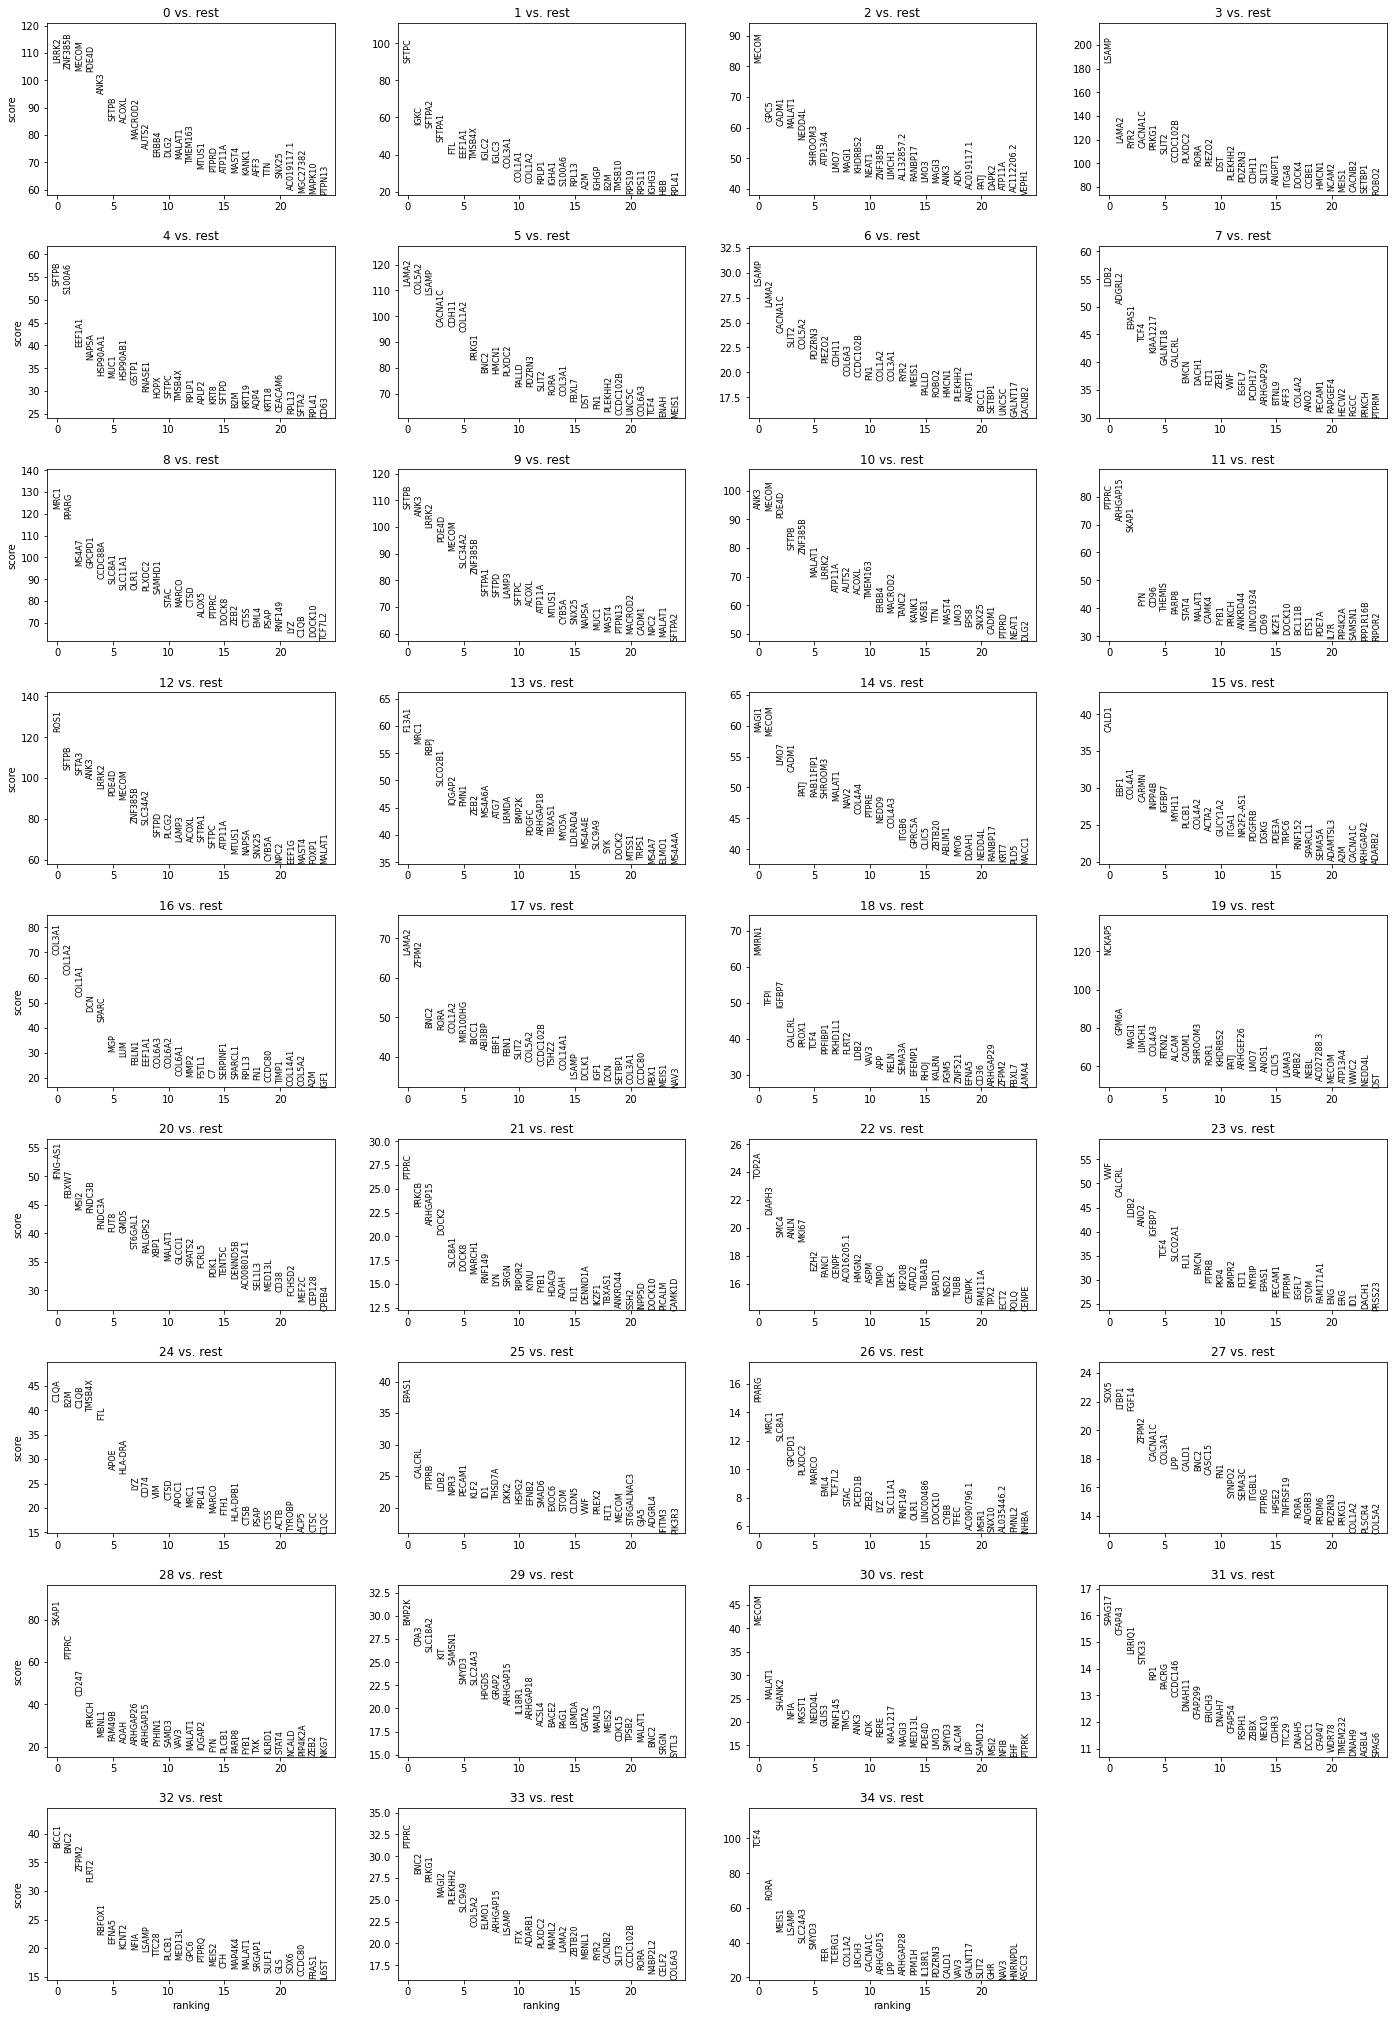

top gene names
top gene names


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,LRRK2,SFTPC,MECOM,LSAMP,SFTPB,LAMA2,LSAMP,LDB2,MRC1,SFTPB,...,EPAS1,PPARG,SOX5,SKAP1,BMP2K,MECOM,SPAG17,BICC1,PTPRC,TCF4
1,ZNF385B,IGKC,GPC5,LAMA2,S100A6,COL5A2,LAMA2,ADGRL2,PPARG,ANK3,...,CALCRL,MRC1,LTBP1,PTPRC,CPA3,MALAT1,CFAP43,BNC2,BNC2,RORA
2,MECOM,SFTPA2,CADM1,RYR2,EEF1A1,LSAMP,CACNA1C,EPAS1,MS4A7,LRRK2,...,PTPRB,SLC8A1,FGF14,CD247,SLC18A2,SHANK2,LRRIQ1,ZFPM2,PRKG1,MEIS1
3,PDE4D,SFTPA1,MALAT1,CACNA1C,NAPSA,CACNA1C,SLIT2,TCF4,GPCPD1,PDE4D,...,LDB2,GPCPD1,ZFPM2,PRKCH,KIT,NFIA,STK33,FLRT2,MAGI2,LSAMP
4,ANK3,FTL,NEDD4L,PRKG1,HSP90AA1,CDH11,COL5A2,KIAA1217,CCDC88A,MECOM,...,NPR3,PLXDC2,CACNA1C,MBNL1,SAMSN1,MGST1,RP1,RBFOX1,PLEKHH2,SLC24A3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26179,MEIS1,GPHN,BNC2,TOX,DLEU2,AC010998.1,PPP1R16B,RUNX1,SOX5,ARHGAP6,...,BICC1,NNMT,TMPRSS2,MAGI3,FMO2,FGF7,C2,KCNQ3,BLZF1,SNX25
26180,LSAMP,ZFAND3,ZNF521,ERBB4,FTX,TMEM163,ERP27,MCTP2,SFTPB,PLCG2,...,NCAM2,MEIS1,FAM160A1,ARHGAP24,CCBE1,NAV3,STAM,AL137009.1,MMP28,MAGI1
26181,ZEB1,CDKAL1,ZEB1,TMEM163,MAML2,ACOXL,AL158166.2,KLF12,PTPRG,ZEB2,...,NR2F2-AS1,NFX1,AC010998.1,CADM1,SVEP1,BICC1,MIR181A1HG,TTC6,NDUFAB1,CSTB
26182,ZEB2,FHIT,ZEB2,CCDC141,NEAT1,AL132857.2,PTPRB,ROR1,PTPRK,ELMO1,...,SLC24A3,EPB41L2,KHDRBS2,PTK2,NR2F1-AS1,LAMA4,CLIC4,MGC27382,STARD10,SECISBP2L


In [47]:
#print(display.HTML('<h1>{algorithm} first phase QC</h1><a class="anchor-link" href="#{algorithm}-first-phase-QC">¶</a>'.format(algorithm=algorithm)))
combined_scanpy = combined[combined.obs.n_genes_by_counts < 8000, :]
combined_scanpy = combined_scanpy[combined_scanpy.obs.pct_counts_mt < 2.5, :]

scanpy.pp.normalize_total(combined_scanpy, target_sum=30000)
scanpy.pp.log1p(combined_scanpy)
scanpy.pp.highly_variable_genes(combined_scanpy, min_mean=0.0125, max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(combined_scanpy)
combined_scanpy.raw = combined_scanpy
combined_scanpy = combined_scanpy[:, combined_scanpy.var.highly_variable]

scanpy.pp.regress_out(combined_scanpy, ['total_counts', 'pct_counts_mt'])
scanpy.pp.scale(combined_scanpy, max_value=10)
scanpy.tl.pca(combined_scanpy, svd_solver='arpack')
scanpy.pl.pca(combined_scanpy)

scanpy.pl.pca_variance_ratio(combined_scanpy, log=True)

scanpy.pp.neighbors(combined_scanpy, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(combined_scanpy)
scanpy.pl.umap(combined_scanpy)

scanpy.tl.louvain(combined_scanpy)
scanpy.pl.umap(combined_scanpy, color=['louvain'])

scanpy.tl.leiden(combined_scanpy)
scanpy.pl.umap(combined_scanpy, color=['leiden'])

scanpy.tl.rank_genes_groups(combined_scanpy, 'leiden', method='t-test')
scanpy.pl.rank_genes_groups(combined_scanpy, n_genes=25, sharey=False, gene_symbols='gene_name')

combined_top_gene_ids = pandas.DataFrame(combined_scanpy.uns['rank_genes_groups']['names'])    
print('top gene names')
combined_top_gene_names = combined_top_gene_ids.applymap(lambda x: v29_gene_id_to_name.get(x, x))
print('top gene names')
combined_top_gene_names

# UMAP uniq reads

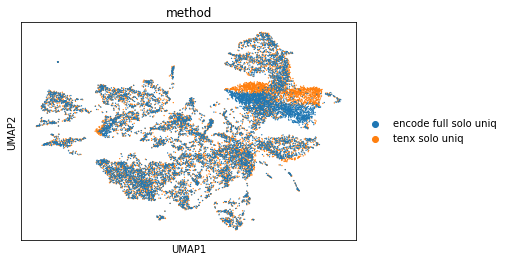

In [48]:
scanpy.pl.umap(combined_scanpy, color=['method'])

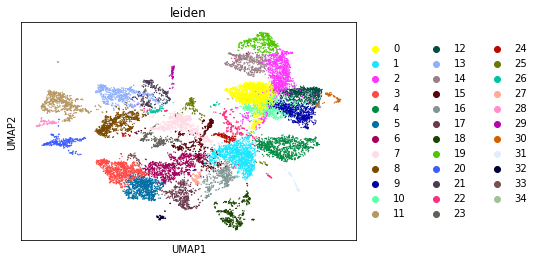

In [49]:
scanpy.pl.umap(combined_scanpy, color=['leiden'])